In this notebook I want to implement K-Means clustering algorithm on some simple dataset. I've picked Video Games Sales dataset from Kaggle located under this link: https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings/data. I will try to pick the best games for myself based on their data.

In [29]:
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.mode.chained_assignment = None

## Constants

In [30]:
DATA_DIR = "./Video_Games_Sales_as_at_22_Dec_2016.csv"

## Loading data

Reading .csv file

In [31]:
df_raw = pd.read_csv(DATA_DIR)

Presenting data

In [32]:
print("Samples: " + str(df_raw.shape[0]))
print("Features: " + str(df_raw.shape[1]))

Samples: 16719
Features: 16


In [33]:
df_raw.head(10)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,Nintendo,E
9,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing

In [34]:
df_processed = df_raw.copy()

- Leaving only important columns

In [35]:
COLUMNS_FOR_ANALYSIS = ["Name", "Platform", "Global_Sales", "Critic_Score",
                        "User_Score", "User_Count", "Critic_Count"]
df_processed = df_raw[COLUMNS_FOR_ANALYSIS]

- Games must be only for consoles that I am using:

In [36]:
PLATFORM_OF_INTEREST = ["3DS", "PC", "PS3", "PS4"]
df_processed = df_raw[df_raw["Platform"].isin(PLATFORM_OF_INTEREST)]

- Removing samples where Critic Score, Critic Count, User Score, User Cout is nan

In [37]:
df_processed = df_processed.dropna();

- Creating features that will corellate Critic Score and Critic Count as well as User Score and User Count

In [38]:
df_processed["Critic_Score"] = df_processed["Critic_Score"].apply(float)
df_processed["Critic_Count"] = df_processed["Critic_Count"].apply(float)
df_processed["Critic_Score_Sum"] = df_processed["Critic_Score"] * df_processed["Critic_Count"]

In [39]:
df_processed["User_Score"] = df_processed["User_Score"].apply(float)
df_processed["User_Count"] = df_processed["User_Count"].apply(float)
df_processed["User_Score_Sum"] = df_processed["User_Score"] * df_processed["User_Count"]

- Drop index

In [40]:
df_processed = df_processed.reset_index(drop=True)

- Creating input data

In [41]:
df_input = df_processed[["Global_Sales", "User_Score_Sum", "Critic_Score_Sum"]]
df_labels = df_processed[["Name", "Platform"]]

## Presenting data

In [42]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

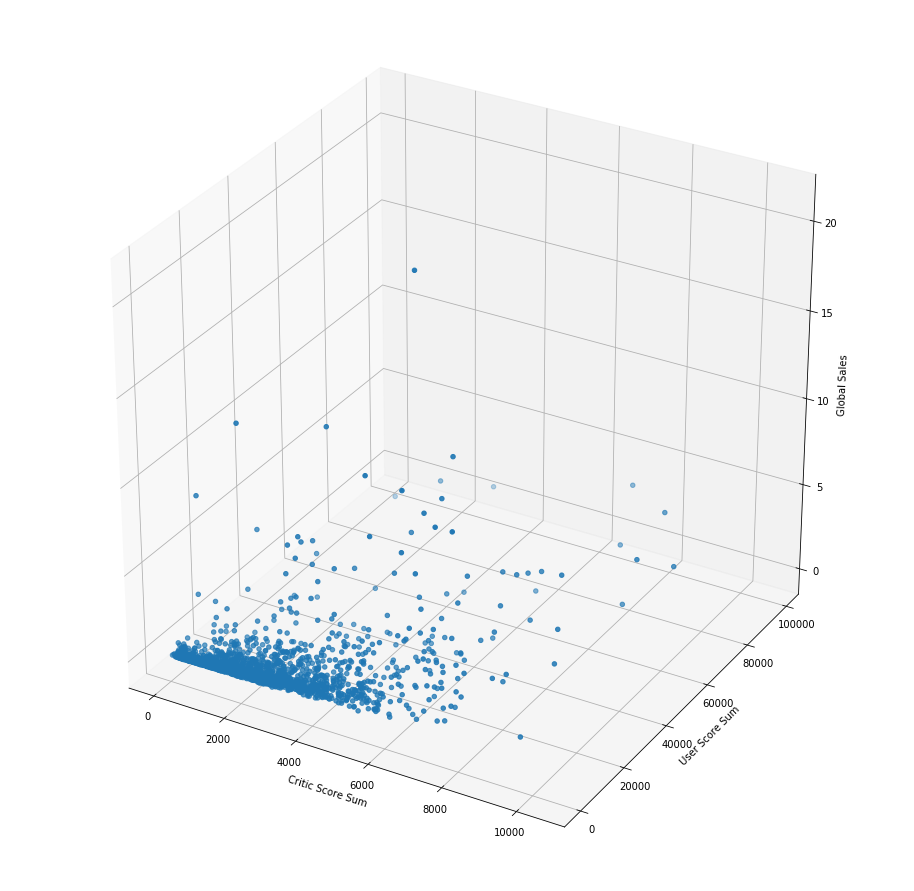

In [43]:
ax.scatter(df_input["Critic_Score_Sum"], df_input["User_Score_Sum"], df_input["Global_Sales"])
ax.set_xlabel("Critic Score Sum")
ax.set_ylabel("User Score Sum")
ax.set_zlabel("Global Sales")
plt.show()

## K-Means algorithm - raw implementation

In [44]:
class KMeans():
    """Implementation of unsupervised Machine Learning algorithm K-Means used for data 
    clustering. Data is aggregated into 'k' groups. Data sample is assigned to group based
    in it's distance from centroid which is initialized randomly at start and then changed
    by calculating mean of samples assigned to it's group.
    
     Arguments:
    ---------
    k: int
        Number of centroids/data clusters.
    iteration_limit: int
        Maximum numbers of iterations that algorithm can perform in order to reach convergence.     
    """
    @staticmethod
    def _l2_euclidean_distance(p, q):
        """Implementation of similarity function using L2 - Euclidean Distance."""
        return np.sqrt(np.sum(np.square(p - q)))
    
    def __init__(self, k=2, iteration_limit=300):
        self.k = k
        self.iteration_limit = iteration_limit 
        self.centroids = dict()
        self.iter_done = 0
        
    def _init_centroids(self, data):
        """Picking self.k random samples from data and setting them as centroids."""
        samples_num, _ = data.shape
        for i in range(self.k):
            # new centroids are randomly picked samples from inserted data
            self.centroids[i] = data[np.random.randint(0, samples_num)]
    
    def _create_clusters(self, data):
        """Assigning data samples to clusters based on their distance to centroids."""
        
        # init cluster containers with empty lists
        clusters = dict()
        for k in range(self.k):
            clusters.setdefault(k, list())
            
        # get closest cluster to each sample and store it's index in clusters dictionary
        for sample_index, sample in enumerate(data):
            assigned_centroid_index = self._assign_closest_centroid(sample)
            clusters[assigned_centroid_index].append(sample_index)
        return clusters
    
    def _assign_closest_centroid(self, sample):
        """Returning index of closest centroid to inserted sample."""
        closest_centroid_index = 0
        closest_dist = None
        for centroid_index, centroid in self.centroids.items():
            
            # calculating distance of samples from cluster
            dist = self._l2_euclidean_distance(sample, centroid)
            
            # updated closest centroid index based on calculated dist value
            if closest_dist is None:
                closest_dist = dist
                closest_centroid_index = centroid_index
            elif dist < closest_dist:
                closest_centroid_index = centroid_index
                closest_dist = dist
                
        return closest_centroid_index
    
    def _calculate_centroids(self, data, clusters):
        """ Calculate new centroids based on mean of the samples in every cluster."""
        for k in range(self.k):
            # new centroid is an artificial sample created from mean values of features
            # of all samples in cluster
            _, features_num = data.shape
            self.centroids[k] = np.mean(data[clusters[k]], axis=0) if clusters[k] else np.zeros(features_num)        

    def predict(self, data):
        """Assigning indexes of inserted data samples into self.k clusters."""
        
        # randomly initializing clusters
        self._init_centroids(data)
        
        # updating clusters until interation_limit is reached or nothing was changed
        for i in range(self.iteration_limit):
            
            # tracking number of iterations
            self.iter_done = i
            
            clusters = self._create_clusters(data)
            previous_centroids = copy.deepcopy(self.centroids)
            self._calculate_centroids(data, clusters)
            
            # stopping if centroids didn't change
            if all(previous_centroids[k].tolist() == self.centroids[k].tolist() for k in self.centroids.keys()):
                break
                
        return clusters

## Data clustering

In [45]:
K = 5

In [46]:
k_means = KMeans(k=K)

In [47]:
clusters = k_means.predict(df_input.values)

In [48]:
for centroid, value in k_means.centroids.items():
    print("Centroid no. " + str(centroid) + ":" + str(value))

Centroid no. 0:[  1.19341808e+00   3.80937288e+03   3.87790960e+03]
Centroid no. 1:[  2.61700000e+00   7.31402900e+04   6.21710000e+03]
Centroid no. 2:[  1.83054687e+00   1.18925422e+04   4.34280469e+03]
Centroid no. 3:[  3.12666667e+00   2.72178667e+04   5.63758333e+03]
Centroid no. 4:[  3.96114600e-01   5.13491130e+02   1.79676295e+03]


In [49]:
print("Clustering finished after " + str(k_means.iter_done) + " iterations.")

Clustering finished after 46 iterations.


In [50]:
game_groups = dict()
for k in range(K):
    game_groups[k] = df_processed.iloc[clusters[k],:]
    print("Group " + str(k) + " samples: " + str(game_groups[k].shape[0]))

Group 0 samples: 354
Group 1 samples: 10
Group 2 samples: 128
Group 3 samples: 48
Group 4 samples: 1274


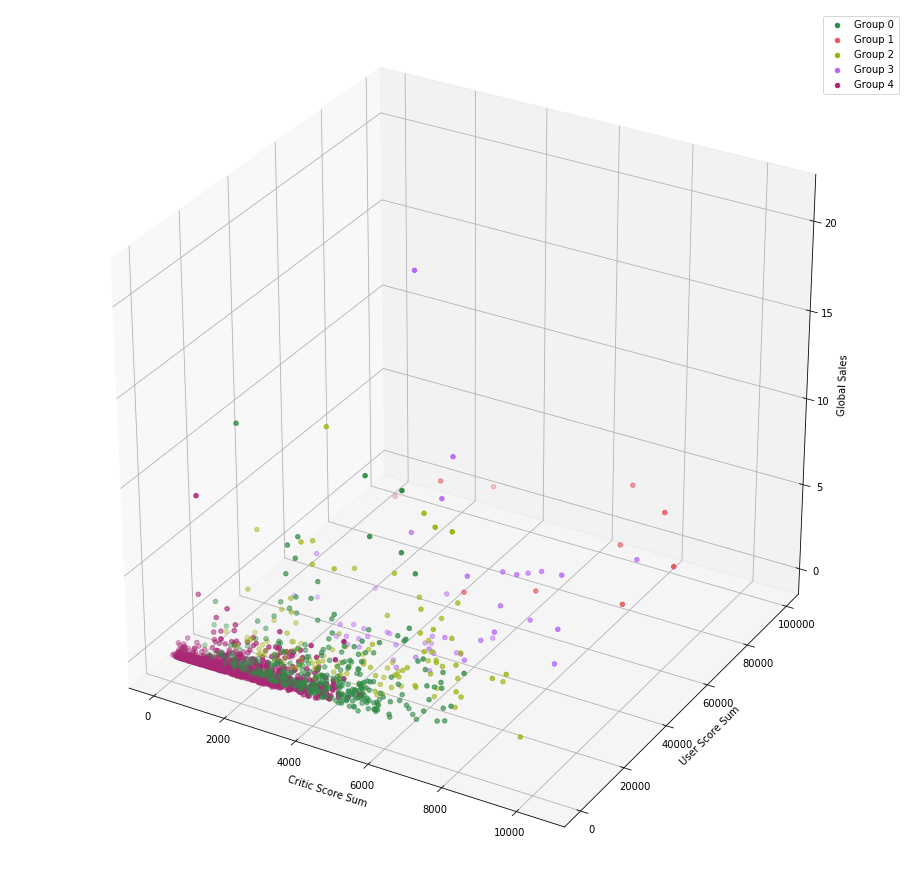

In [51]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("Critic Score Sum")
ax.set_ylabel("User Score Sum")
ax.set_zlabel("Global Sales")

r = lambda: random.randint(0, 255)
COLORS = ["#%02X%02X%02X" % (r(),r(),r()) for _ in range(K)]

plots = list()
labels = list()
for k, df_group in game_groups.items():
    label_ = "Group {}".format(k)
    plot_ = ax.scatter(df_group["Critic_Score_Sum"], df_group["User_Score_Sum"], 
                       df_group["Global_Sales"], c=COLORS[k], label=label_)
    plots.append(plot_)
    labels.append(label_)
    
plt.legend(plots, labels)
plt.show()

## Conclusions

In [52]:
def plot_games(df):
    for index, row in df.iterrows():
        print("- " + str(row["Name"] + ", " + str(row["Platform"])))

- Games with extremely high Critic and User Scores as well as high amount of sales.

In [56]:
plot_games(game_groups[1])

- The Last of Us, PS3
- Uncharted 4: A Thief's End, PS4
- The Witcher 3: Wild Hunt, PS4
- The Elder Scrolls V: Skyrim, PC
- Bloodborne, PS4
- Half-Life 2, PC
- Portal 2, PC
- The Witcher 3: Wild Hunt, PC
- BioShock Infinite, PC
- Counter-Strike: Source, PC


- Games with best Critic scores, good User Scores and very high sell ratio.

In [57]:
plot_games(game_groups[3])

- Grand Theft Auto V, PS3
- Grand Theft Auto V, PS4
- Grand Theft Auto IV, PS3
- Fallout 4, PS4
- Uncharted 3: Drake's Deception, PS3
- Uncharted 2: Among Thieves, PS3
- Red Dead Redemption, PS3
- Metal Gear Solid 4: Guns of the Patriots, PS3
- LittleBigPlanet, PS3
- Destiny, PS4
- Diablo III, PC
- StarCraft II: Wings of Liberty, PC
- God of War III, PS3
- Half-Life, PC
- Batman: Arkham Knight, PS4
- Metal Gear Solid V: The Phantom Pain, PS4
- Heavy Rain, PS3
- inFAMOUS: Second Son, PS4
- Battlefield 3, PC
- Guild Wars 2, PC
- The Order: 1886, PS4
- No Man's Sky, PS4
- Beyond: Two Souls, PS3
- Battlefield 4, PC
- Fallout 4, PC
- Grand Theft Auto V, PC
- Fallout: New Vegas, PC
- Call of Duty 4: Modern Warfare, PC
- Empire: Total War, PC
- Tomb Raider, PC
- Fallout 3, PC
- Mass Effect 3, PC
- Far Cry 3, PC
- The Witcher 2: Assassins of Kings, PC
- Borderlands 2, PC
- Call of Duty: Modern Warfare 2, PC
- Dragon Age: Inquisition, PC
- Mass Effect, PC
- Dragon Age II, PC
- Deus Ex: Human Re

- Games which are better than average ones.

In [58]:
plot_games(game_groups[2])

- Call of Duty: Modern Warfare 3, PS3
- Super Mario 3D Land, 3DS
- Gran Turismo 5, PS3
- Call of Duty: Modern Warfare 2, PS3
- Call of Duty: Advanced Warfare, PS4
- Battlefield 3, PS3
- Call of Duty 4: Modern Warfare, PS3
- Assassin's Creed III, PS3
- The Elder Scrolls V: Skyrim, PS3
- World of Warcraft, PC
- Assassin's Creed II, PS3
- Batman: Arkham City, PS3
- Final Fantasy XIII, PS3
- Uncharted: Drake's Fortune, PS3
- Uncharted: The Nathan Drake Collection, PS4
- Batman: Arkham Asylum, PS3
- Watch Dogs, PS4
- Far Cry 4, PS4
- Assassin's Creed: Unity, PS4
- Tom Clancy's The Division, PS4
- Battlefield 4, PS4
- Assassin's Creed Syndicate, PS4
- Far Cry 3, PS3
- L.A. Noire, PS3
- The Legend of Zelda: A Link Between Worlds, 3DS
- The Sims 4, PC
- Killzone 2, PS3
- Star Wars: The Old Republic, PC
- Middle-Earth: Shadow of Mordor, PS4
- inFAMOUS, PS3
- Assassin's Creed IV: Black Flag, PS4
- Killzone: Shadow Fall, PS4
- Resistance 2, PS3
- Overwatch, PS4
- Dying Light, PS4
- DriveClub, PS4

There is no much info about 3DS games as the console is mostly popular in Japan. This platform should be evaluated separately.